In [0]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, adjusted_mutual_info_score as ami, v_measure_score

In [0]:
random_seed = 1
wine = 'winequality-white.csv'
df = df = pd.read_csv(wine, sep=';')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
# Standardize
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# Clustering code

In [0]:
from sklearn.metrics import v_measure_score
def kmeans(X, Y, random_seed, ds_name):
  wcss = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_seed)
      start = datetime.datetime.now()
      kmeans.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      labels_pred = kmeans.labels_
      wcss.append(kmeans.inertia_)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,wcss, marker='o')
  plt.title('K means - Elbow Method - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('K means - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()

def em(X, Y, random_seed, ds_name):
  bic = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      gmm = GMM(n_components=i, random_state=random_seed)
      start = datetime.datetime.now()
      gmm.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      #BIC score (lower better)
      bic.append(gmm.bic(X))
      labels_pred = gmm.predict(X)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,bic, marker='o')
  plt.title('EM - BIC to choose optimal components - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('BIC')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('EM - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()


# Random Forest Feature Selection

In [0]:
def rf(X,Y,random_seed, no_features, ds_name):
  # Create a random forest classifier
  clf = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
  clf.fit(X, Y)
  feat_labels = X.columns
  #for feature in zip(feat_labels, clf.feature_importances_):
   #   print(feature)

  feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
  feat_importances.nsmallest(no_features).plot(kind='barh')
  plt.title('RF - Feature Importances - ' + ds_name)
  print('Feature importances')
  print(feat_importances.nlargest(no_features))
  sel = SelectFromModel(clf)
  sel.fit(X, Y)
  selected_feat= X.columns[(sel.get_support())]
  print('Selected features')
  print(selected_feat)


# Neural Networks Code

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
def NN(X, Y, plt_title, random_seed=1):
    # Hyperparameter tuning, hidden layer size
    X_train, X_val_test, y_train, y_val_test = \
        train_test_split(X, Y, train_size=0.8, random_state=random_seed)
    hidden_layer_sizes = [2, 4, 6, 8, 10]
    train_score = []
    test_score = []
    for i in hidden_layer_sizes:
        mlp_model = MLPClassifier(hidden_layer_sizes=(i,),random_state=random_seed)
        mlp_model.fit(X=X_train, y=y_train)
        y_train_predict = mlp_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        train_score.append(train_accuracy)

        y_val_test_predict = mlp_model.predict(X_val_test)
        test_accuracy = accuracy_score(y_val_test, y_val_test_predict)
        test_score.append(test_accuracy)

    df_layers = pd.DataFrame({
        'Hidden layer sizes': hidden_layer_sizes,
        'train score': train_score,
        'validation score': test_score
    })
    print('Hidden layers**************')
    print(df_layers)
    print('hidden_layer_sizes: ', hidden_layer_sizes)
    print('train_score: ', train_score)
    print('test_score: ', test_score)

    # Plot Max depth
    plt.plot(hidden_layer_sizes, train_score, 'o-', color="r",
              label="Training score")
    plt.plot(hidden_layer_sizes, test_score, 'o-', color="g",
              label="Test score")
    plt.legend(loc="best")
    plt.xlabel('Hidden layer sizes')
    plt.ylabel('Accuracy Score')
    plt.title(plt_title)
    plt.show()

# RF - Wine Dataset

RF - Wine Dataset
Feature importances
alcohol                 0.114186
density                 0.103508
volatile acidity        0.098527
free sulfur dioxide     0.094774
total sulfur dioxide    0.092127
residual sugar          0.089798
chlorides               0.086747
pH                      0.085846
sulphates               0.080021
citric acid             0.079591
fixed acidity           0.074877
dtype: float64
Selected features
Index(['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide',
       'density', 'alcohol'],
      dtype='object')


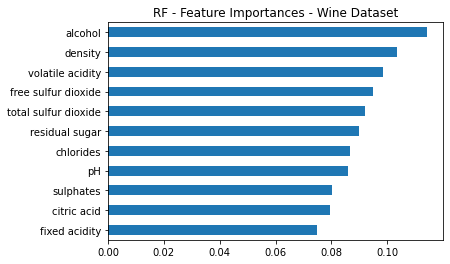

In [119]:
print('RF - Wine Dataset')
rf(X_std, Y, random_seed=random_seed, no_features=11, ds_name='Wine Dataset')

# RF with kmeans - Wine Dataset

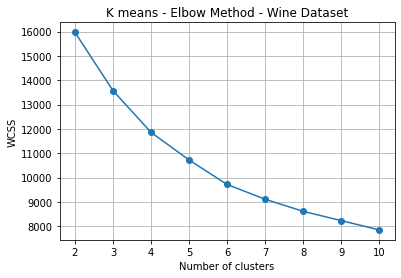

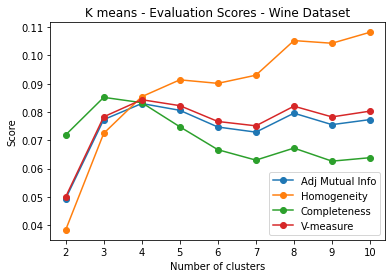

In [120]:
# Choosing features from Selectfrommodel
X_reduced = X_std[['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide',
       'density', 'alcohol']]

kmeans(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'K means clusters - Wine Dataset')

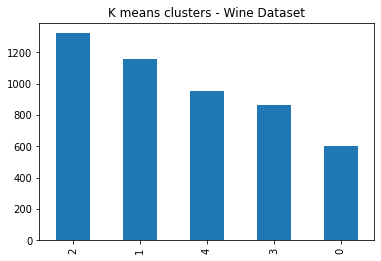

In [121]:
# Choosing k=5 appx from elbow and score peak
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=random_seed)
kmeans1.fit(X_reduced)
labels_pred_k = pd.DataFrame(data = kmeans1.labels_, columns=['Cluster labels'])
labels_pred_k['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Wine Dataset')

# RF with Neural Networks - Wine Dataset

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.541348          0.504082
1                   4     0.533435          0.508163
2                   6     0.547473          0.507143
3                   8     0.543645          0.517347
4                  10     0.544921          0.516327
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.5413476263399694, 0.5334354262378764, 0.5474732006125574, 0.5436447166921899, 0.544920877998979]
test_score:  [0.5040816326530613, 0.5081632653061224, 0.5071428571428571, 0.5173469387755102, 0.5163265306122449]


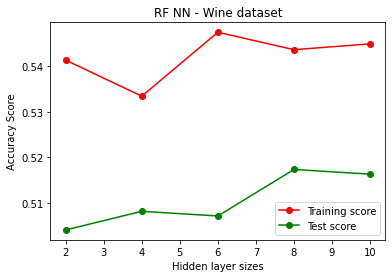

In [122]:
NN(X=X_reduced, Y=Y, plt_title='RF NN - Wine dataset', random_seed=random_seed)

# RF K means - NN - Wine

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.449974          0.443878
1                   4     0.449974          0.443878
2                   6     0.481113          0.464286
3                   8     0.481113          0.464286
4                  10     0.481113          0.464286
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.4499744767738642, 0.4499744767738642, 0.48111281265952016, 0.48111281265952016, 0.48111281265952016]
test_score:  [0.44387755102040816, 0.44387755102040816, 0.4642857142857143, 0.4642857142857143, 0.4642857142857143]


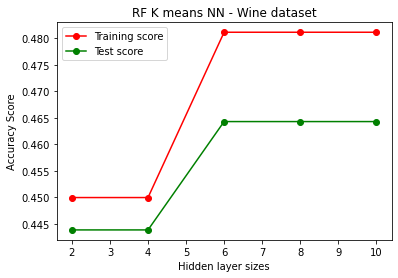

In [123]:
# Using labels from k means as feature X
NN(X=labels_pred_k, Y=Y, plt_title='RF K means NN - Wine dataset', random_seed=random_seed)

# RF with EM - Wine Dataset

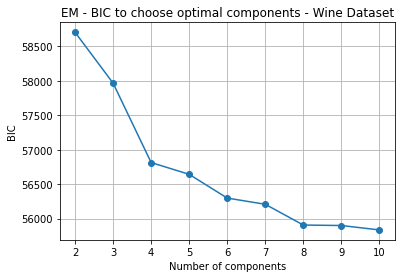

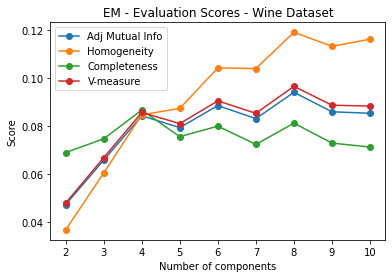

In [124]:
em(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'EM clusters - Wine Dataset')

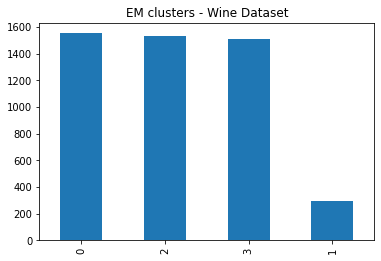

In [125]:
#Choosing components = 4 where BIC lowers significantly
gmm1 = GMM(n_components=4, random_state=random_seed)
gmm1.fit(X_reduced)
labels_pred_em = pd.DataFrame(data = gmm1.predict(X_reduced), columns=['Cluster labels'])
labels_pred_em['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Wine Dataset')

# PCA EM - NN - Wine

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.449974          0.443878
1                   4     0.449974          0.443878
2                   6     0.468096          0.459184
3                   8     0.468096          0.459184
4                  10     0.468096          0.459184
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.4499744767738642, 0.4499744767738642, 0.46809596733027053, 0.46809596733027053, 0.46809596733027053]
test_score:  [0.44387755102040816, 0.44387755102040816, 0.45918367346938777, 0.45918367346938777, 0.45918367346938777]


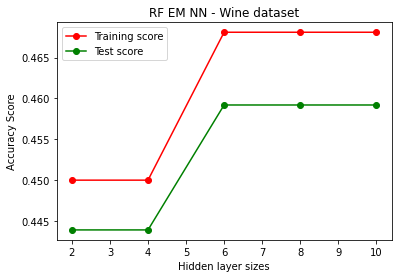

In [126]:
# Using labels from EM as feature X
NN(X=labels_pred_em, Y=Y, plt_title='RF EM NN - Wine dataset', random_seed=random_seed)

# ***Seeds Dataset***

# Load Seeds data

In [127]:
random_seed = 1
seeds = 'Seed_Data.csv'
df2 = pd.read_csv(seeds)
X2 = df2.iloc[:, :-1]
Y2 = df2.iloc[:, -1]
# Standardize
X_std2 = StandardScaler().fit_transform(X2)
X_std2 = pd.DataFrame(data=X_std2, columns=X2.columns)
X_std2.shape
# X, X_test, Y, Y_test = train_test_split(data_X, data_y, train_size=0.8, random_state=random_seed)

(210, 7)

# RF - Seeds dataset

Feature importances
P         0.218868
LKG       0.216947
A         0.208450
WK        0.138465
LK        0.103308
A_Coef    0.075750
C         0.038213
dtype: float64
Selected features
Index(['A', 'P', 'LKG'], dtype='object')


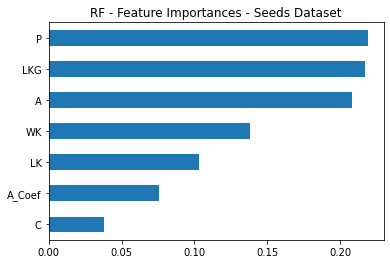

In [128]:
rf(X=X_std2, Y=Y2, random_seed=random_seed, no_features=7, ds_name='Seeds Dataset')

# RF with K means - Seeds Dataset

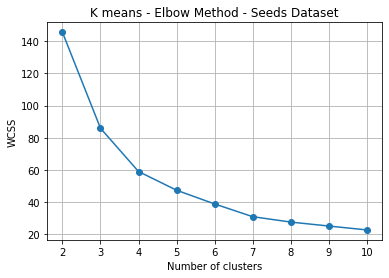

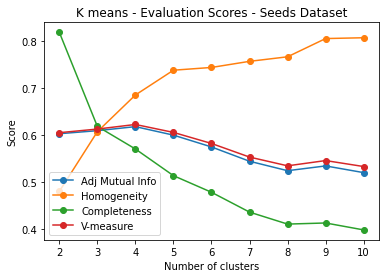

In [129]:
# Choosing features from Selectfrommodel
X_reduced2 = X_std2[['A', 'P', 'LKG']]
kmeans(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'K means clusters - Seeds Dataset')

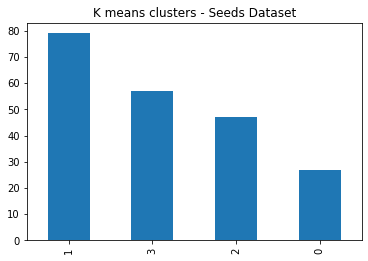

In [130]:
# Choosing k=4 appx from elbow and score peak
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=random_seed)
kmeans2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = kmeans2.labels_, columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Seeds Dataset')

# RF with EM - Seeds Dataset

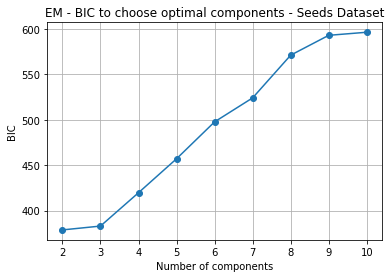

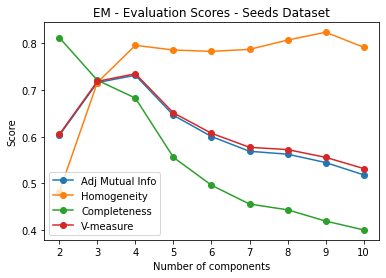

In [131]:
em(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


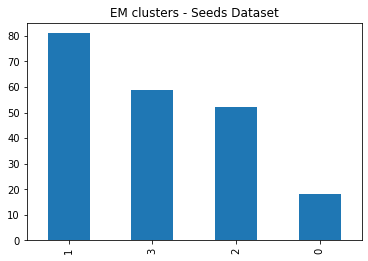

In [132]:
#Choosing components = 4 where BIC lowers significantly
gmm2 = GMM(n_components=4, random_state=random_seed)
gmm2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = gmm2.predict(X_reduced2), columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Seeds Dataset')
plt.show()